In [61]:
from sklearn.datasets import make_circles

n_samples=1000

X , y=make_circles(n_samples,noise=0.03,random_state=42)

In [62]:
print(f'first 5 x features are : {X[:5]}')
print(f'first 5 y labels are : {y[:5]}')

first 5 x features are : [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
first 5 y labels are : [1 1 1 1 0]


In [63]:
import pandas as pd
circles=pd.DataFrame({'X1':X[:,0],
                      'X2':X[:,1],
                      'y':y[:]})
circles

,X1,X2,y
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
...,...,...,...
995,0.244054,0.944125,0
996,-0.978655,-0.272373,0
997,-0.136900,-0.810012,1
998,0.670362,-0.767502,0


In [64]:
circles.y.value_counts()


y
1    500
0    500
Name: count, dtype: int64

In [65]:
X.shape,y.shape

((1000, 2), (1000,))

In [66]:
X.ndim,y.ndim

(2, 1)

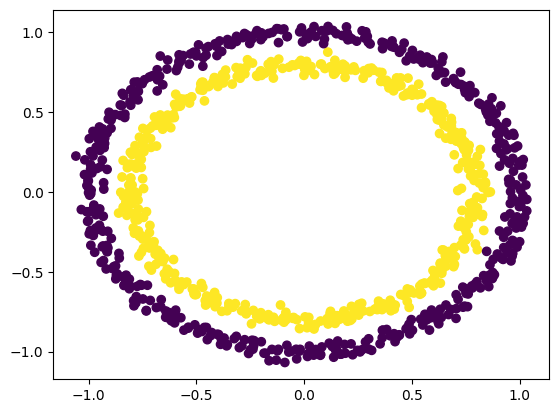

In [105]:
import matplotlib.pyplot as plt
plt.scatter(X[:,0],X[:,1],c=y )

In [67]:
import torch
X=torch.from_numpy(X).type(torch.float)

y=torch.from_numpy(y).type(torch.float)
X[:5],y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [68]:
#splitting the data into train and test datasets
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(
    X, y, test_size=0.2, random_state=42)

len(X_test),len(y_test),len(X_train),len(y_train)


(200, 200, 800, 800)

In [69]:
#building a model
import torch
from torch import nn
device= 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [75]:
#constructing a model with nn.Module subclass
class circleModel0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1=nn.Linear(in_features=2, out_features=5)

    self.layer2=nn.Linear(in_features=5, out_features=1)

  def forward(self,x):
    return self.layer2(self.layer1(x))

model_0=circleModel0().to(device)
model_0

circleModel0(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [76]:
#making predictions with untrained model
# untrained_pred=model_0(X_test.to(device))
untrained_pred = model_0(X_test.to(device))
print(f'length of predictions: {len(untrained_pred)}   shape: {untrained_pred.shape}')
print(f'length of test samples: {len(y_test)} shape{y_test.shape}')
print(f'first 10 predictions: {untrained_pred[:10]}')
print(f'first 10 test labels : {y_test[:10]}')

length of predictions: 200   shape: torch.Size([200, 1])
length of test samples: 200 shapetorch.Size([200])
first 10 predictions: tensor([[1.0993],
        [1.1875],
        [0.8822],
        [1.1608],
        [0.9045],
        [0.9582],
        [1.1889],
        [1.1352],
        [0.8815],
        [1.1937]], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 test labels : tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [90]:
#setting up loss fn and optimizer

loss_fn=nn.BCEWithLogitsLoss()
optimizer=torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [91]:
#creating evaluation matrix
#accuracy
def accuracy(y_true, y_pred):
  correct=torch.eq(y_true,y_pred).sum().item()
  acc=(correct/len(y_pred))*100
  return acc

In [79]:
#training the model
#logits->prediction_prob->prediction_labels
y_logits=model_0(X_test.to(device))[:5]
y_logits


tensor([[1.0993],
        [1.1875],
        [0.8822],
        [1.1608],
        [0.9045]], device='cuda:0', grad_fn=<SliceBackward0>)

In [82]:
y_pred_prob=torch.sigmoid(y_logits)
y_pred_prob

tensor([[0.7501],
        [0.7663],
        [0.7073],
        [0.7615],
        [0.7119]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [84]:
y_pred=torch.round(y_pred_prob)
# or u can do these step in a single line
y_pred_labels=torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))
print(torch.eq(y_pred.squeeze(),y_pred_labels.squeeze()))
y_pred.squeeze()


tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 1., 1., 1.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [85]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [86]:
#building a training and testing loop


#putting data into target device
X_train,y_train=X_train.to(device),y_train.to(device)

X_test,y_test=X_test.to(device),y_test.to(device)

In [92]:
torch.manual_seed(42)
epochs=100

#building a training and evaluation loop
for epoch in range(epochs):
  #training
  model_0.train()

  #forward pass
  y_logits=model_0(X_train).squeeze()
  y_pred=torch.round(torch.sigmoid(y_logits))

  #calculate loss
  loss=loss_fn(y_logits,y_train)
  acc=accuracy(y_true=y_train,y_pred=y_pred)

  #optimizer
  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  #testng loop
  model_0.eval()
  with torch.inference_mode():
    #forward pass
    test_logits=model_0(X_test).squeeze()
    test_pred=torch.round(torch.sigmoid(test_logits))

    #calculate loss
    test_loss=loss_fn(test_logits,y_test)
    test_acc=accuracy(y_true=y_test,y_pred=test_pred)

  if epoch%10==0:
    print(f'epoch: {epoch}    loss: {loss}   accuracy: {acc:.4f}        test loss: {test_loss:.4f}   test acc: {test_acc:.4f}')

epoch: 0    loss: 0.7052429914474487   accuracy: 50.0000        test loss: 0.7069   test acc: 50.0000
epoch: 10    loss: 0.6970243453979492   accuracy: 50.0000        test loss: 0.6987   test acc: 50.0000
epoch: 20    loss: 0.6943615674972534   accuracy: 50.0000        test loss: 0.6959   test acc: 50.0000
epoch: 30    loss: 0.6934758424758911   accuracy: 50.0000        test loss: 0.6950   test acc: 50.0000
epoch: 40    loss: 0.693173348903656   accuracy: 54.3750        test loss: 0.6946   test acc: 50.5000
epoch: 50    loss: 0.6930657625198364   accuracy: 52.5000        test loss: 0.6945   test acc: 49.0000
epoch: 60    loss: 0.693024754524231   accuracy: 51.8750        test loss: 0.6945   test acc: 49.0000
epoch: 70    loss: 0.6930073499679565   accuracy: 51.7500        test loss: 0.6945   test acc: 47.0000
epoch: 80    loss: 0.6929987668991089   accuracy: 51.2500        test loss: 0.6946   test acc: 46.0000
epoch: 90    loss: 0.6929939985275269   accuracy: 51.0000        test loss: 

In [96]:
#making predictions using the trained model
import requests
from pathlib import Path

if Path('helper_functions.py').is_file():
  print('already exists, skipping download')
else:
  print('downloading')
  request=requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
  with open('helper_functions.py','wb') as f:
    f.write(request.content)


from helper_functions import plot_predictions, plot_decision_boundary

downloading


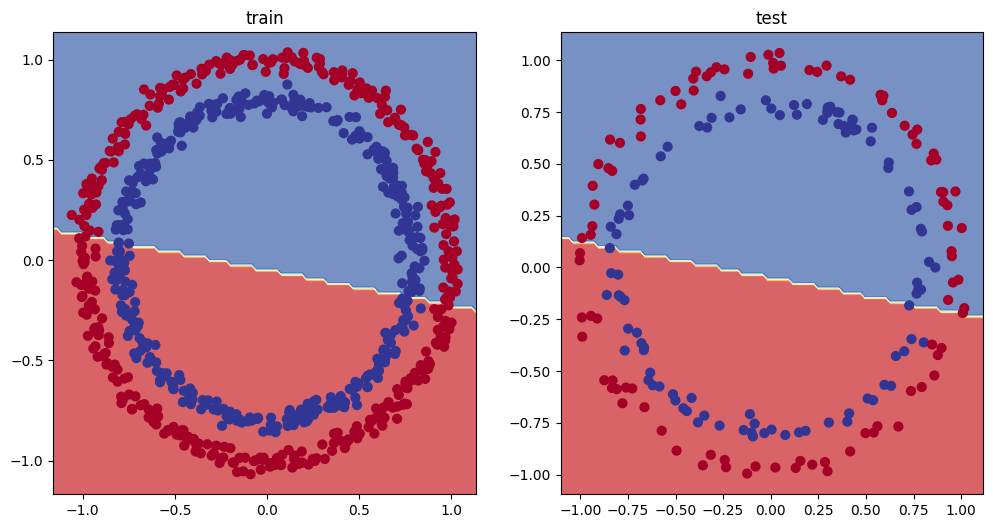

In [107]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('train')
plot_decision_boundary(model_0,X_train,y_train)

plt.subplot(1,2,2)
plt.title('test')
plot_decision_boundary(model_0,X_test,y_test)